# Simulataneous Fitting in iminuit

This notebook demonstrates how to simultaneously fit two datasets, where the distributions have shared parameters, through the use of `CostSum`.

In [1]:
from iminuit import Minuit
from iminuit.cost import UnbinnedNLL
from iminuit.util import make_with_signature, describe
from matplotlib import pyplot as plt
import numpy as np
import numba as nb


In [2]:
# norm_pdf from numba_stats is a compiled function
# without a function signature, so we create one
from numba_stats import norm_pdf

print(f"before {describe(norm_pdf)=}")
normal_pdf = make_with_signature(norm_pdf, "x", "μ", "σ")
print(f"after  {describe(normal_pdf)=}")

before describe(norm_pdf)=()
after  describe(normal_pdf)=('x', 'μ', 'σ')


In [3]:
# generate two data sets which are fitted simultaneously
rng = np.random.default_rng(1)

width = 2.0
data1 = rng.normal(1, width, size=1000)
data2 = rng.normal(2, width, size=1000)

In [15]:
# rename non-shared parameters to create correct signature
pdf1 = make_with_signature(normal_pdf, μ='μ_1')
pdf2 = make_with_signature(normal_pdf, μ='μ_2')

# combine two cost functions with shared parameters
lh = UnbinnedNLL(data1, pdf1) + UnbinnedNLL(data2, pdf2)

print(f"{describe(lh)=}")

describe(lh)=('μ_1', 'σ', 'μ_2')


The `σ` parameter is shared between the data sets.

In [23]:
def plot(cost, xe, minuit, i, ax):
    signature = list(describe(cost[i]))
    data = cost[i].data
    
    values = minuit.values[signature]
    errors = minuit.errors[signature]

    cx = (xe[1:] + xe[:-1]) / 2
    dx = (xe[1] - xe[0])

    ym = normal_pdf(cx, *values) * np.sum(w * dx)
    ax.plot(cx, ym)
    t = ""
    for n, v, e in zip(signature, values, errors):
        t += f"{n} = {v:.3f} ± {e:.3f}\n"
    ax.text(0.01, 0.99, t, transform=ax.transAxes, va='top')

AttributeError: 'numpy.ndarray' object has no attribute 'errorbar'

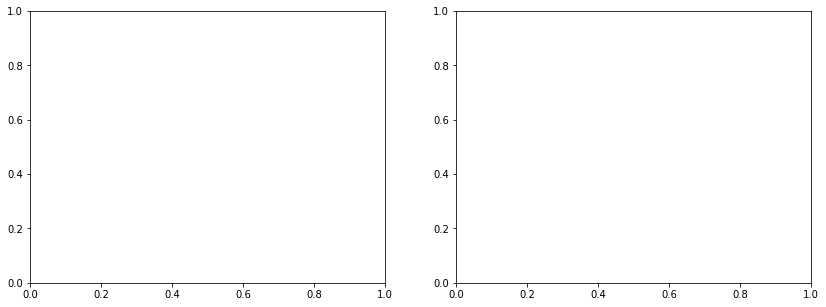

In [26]:
m = Minuit(lh, μ_1=0.2, μ_2=2.2, σ=1.5)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# draw data
for lhi, axi in zip(lh, ax):
    w, xe = np.histogram(lhi.data, bins=100)
    cx = (xe[1:] + xe[:-1]) / 2
    ax.errorbar(cx, w, np.sqrt(w), fmt="b.", capsize=0, zorder=0)
    plot(lhi, m, axi)

m.migrad()  # fit

for lhi, axi in zip(lh, ax):
    plot(lhi, m, axi)